# VelocityHack
Swung London Hackathon
1st-2nd June 2019

In [1]:
import lasio
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#### Load LAS Data

In [2]:
log = lasio.read('data/GN3.las')

Header section Parameter regexp=~P was not found.


In [3]:
log.header

{'Version': [HeaderItem(mnemonic=VERS, unit=, value=2.0, descr=CWLS LOG ASCII STANDARD -V...),
  HeaderItem(mnemonic=WRAP, unit=, value=NO, descr=ONE LINE PER DEPTH STEP)],
 'Well': [HeaderItem(mnemonic=STRT, unit=m, value=8.9916, descr=START DEPTH),
  HeaderItem(mnemonic=STEP, unit=m, value=0.1524, descr=STEP DEPTH),
  HeaderItem(mnemonic=STOP, unit=m, value=2706.1668, descr=STOP DEPTH),
  HeaderItem(mnemonic=NULL, unit=, value=-999.25, descr=NULL VALUE),
  HeaderItem(mnemonic=COMP, unit=, value=, descr=COMPANY),
  HeaderItem(mnemonic=WELL, unit=, value=, descr=WELL),
  HeaderItem(mnemonic=LOC, unit=, value=, descr=LOCATION - AREA),
  HeaderItem(mnemonic=FLD, unit=, value=, descr=FIELD),
  HeaderItem(mnemonic=CTRY, unit=, value=, descr=COUNTRY),
  HeaderItem(mnemonic=DATE, unit=, value=, descr=WELL DATE),
  HeaderItem(mnemonic=XWELL, unit=m, value=, descr=X POS),
  HeaderItem(mnemonic=YWELL, unit=m, value=, descr=Y POS),
  HeaderItem(mnemonic=EDF, unit=, value=6.1, descr=DERRICK FLOOR

In [4]:
log['VP']

array([nan, nan, nan, ..., nan, nan, nan])

#### Plot Velocity Log

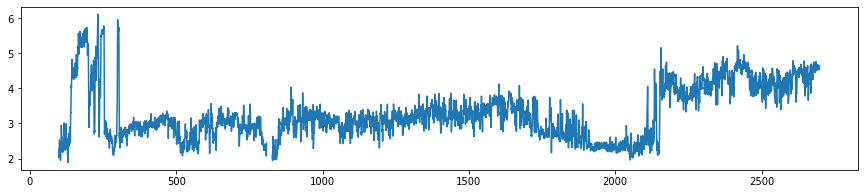

In [7]:
plt.figure(figsize=(15, 3))
plt.plot(log['DEPT'], log['VP'])
plt.show()

In [24]:
%matplotlib inline

from ipywidgets import interactive, FloatRangeSlider, FloatSlider, fixed

def filter_depth(depth, top, bottom):
    depth_idx = np.where((bottom>depth) & (top<depth))    
    return depth_idx

def f(slider_range, depth, vp):
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 3))
    ax.clear()
    top = slider_range[0]
    bottom = slider_range[1]
    above_idx = np.where(depth<top)
    below_idx = np.where(depth>bottom)
    between_idx = filter_depth(depth, top, bottom)
    ax.plot(depth[above_idx], vp[above_idx], c="blue")
    ax.plot(depth[below_idx], vp[below_idx], c="blue")
    ax.plot(depth[between_idx], vp[between_idx], c="red")
    ax.axvline(top)
    ax.axvline(bottom)
    ax.set_ylim(2, 7)
    ax.set_xlim(0, 3000)

    
slider = FloatRangeSlider(min=log['DEPT'].min(), max=log['DEPT'].max(), step=1.)

interactive_plot = interactive(f, slider_range=slider, depth=fixed(log['DEPT']), vp=fixed(log['VP']))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatRangeSlider(value=(683.2854, 2031.873), description='slider_range', max=2706.1668, …

In [26]:
depth_min = slider.value[0]
depth_max = slider.value[1]

depth_idx = filter_depth(log['DEPT'], depth_min, depth_max)
depth_idx

(array([ 4423,  4424,  4425, ..., 10975, 10976, 10977], dtype=int64),)

#### Load curves as Pandas dataframe

In [17]:
log.df().head()

,DTCO,VP,DTSM,VS,RHOB,CGR,VWCL,PHIT
DEPT,,,,,,,,
8.9916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.1440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.2964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.4488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.6012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


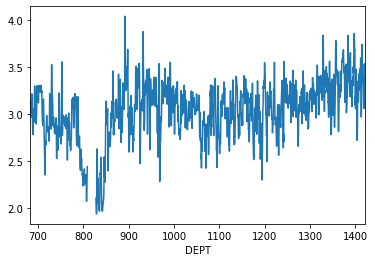

In [18]:
log.df().loc[depth_min:depth_max].VP.plot()

In [21]:
log['DEPT']

array([   8.9916,    9.144 ,    9.2964, ..., 2705.862 , 2706.0144,
       2706.1668])

In [27]:
depth = log['DEPT'][depth_idx].reshape(-1,1)
vp = log['VP'][depth_idx].reshape(-1,1)
# convert to m/s
#vp = vp*1000

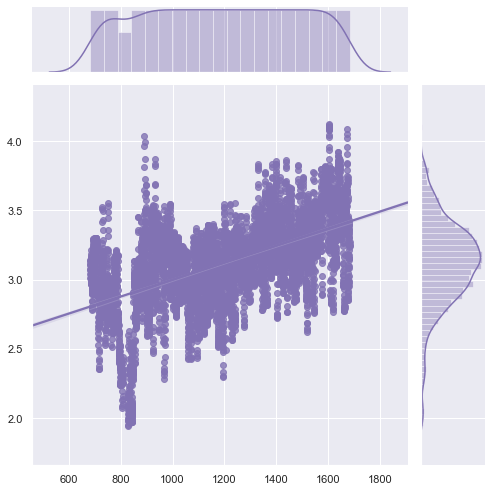

In [31]:
import seaborn as sns
sns.set(style="darkgrid")

g = sns.jointplot(depth, vp, kind="reg", color="m", height=7)

# Simulating pairs of K and V0 

In [32]:
import numpy as np
import matplotlib.pyplot as plt


In [33]:
def simulate_linear_velocity(depth, vel, k_range=(-3, 3), v0_range=(1500,5000), nr_samples = 100000):
    k = np.random.uniform(*k_range, nr_samples)
    v0 = np.random.uniform(*v0_range, nr_samples)
    pred_vel = depth*k+v0
    
    # calculate the errors
    mse = np.mean((vel-pred_vel)**2,axis=0)
    rmse = np.sqrt(mse)
    
    return k, v0, pred_vel, rmse

def plot_rmse_ellipse(ax, k, v0, rmse, cutoff=500):
    
    # lowest rmse indices
    idx = rmse.argsort()[:cutoff]   
    # best fit point
    idx_min = rmse.argmin()    
    
    sc = ax.scatter(k[idx], v0[idx], c=rmse[idx], s=10)
    ax.scatter(k[idx_min], v0[idx_min], c='yellow', s=100, marker='X')
    #plt.colorbar()
    return sc, idx, idx_min

In [ ]:
# simulate 
k, v0, pred_vel, rmse = simulate_linear_velocity(depth, vp)

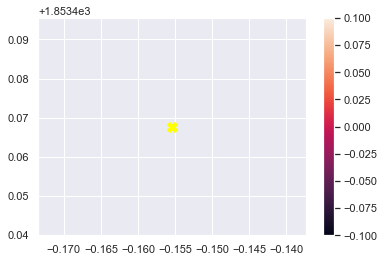

In [27]:
fig, ax = plt.subplots(1, 1)
cutoff = 1500
sc, idx, idx_min = plot_rmse_ellipse(ax, k, v0, rmse, cutoff)
plt.colorbar(sc)

In [402]:
# # get the indexes for the best rmse values

low_rmse_idx = rmse.argsort()[:cutoff]
med_rmse_idx = rmse.argsort()[cutoff:cutoff*2]
high_rmse_idx = rmse.argsort()[cutoff*2:cutoff*3]

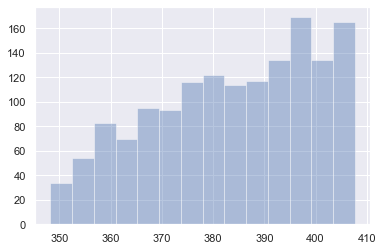

In [403]:
# Plot a simple histogram with binsize determined automatically
sns.distplot(rmse[low_rmse_idx], kde=False, color="b")

In [406]:
# plot all lines through the data
def plot_velocity_predictions(ax, depth, pred_vel, rmse, cutoff=500, nr_samples=5):
    
    # get low, med,high index ranges
    low_rmse_idx = rmse.argsort()[:cutoff]
    med_rmse_idx = rmse.argsort()[cutoff:cutoff*2]
    high_rmse_idx = rmse.argsort()[cutoff*2:cutoff*3]
    
    #
    sample_rmse_idx = np.random.choice(low_rmse_idx, nr_samples)
    
    #fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    lp = ax.plot(depth, pred_vel[:, low_rmse_idx], c='red', alpha=0.1)
    lp = ax.plot(depth, pred_vel[:, med_rmse_idx], c='orange', alpha=0.1)
    lp = ax.plot(depth, pred_vel[:, high_rmse_idx], c='yellow', alpha=0.1)
    lp = ax.plot(depth, pred_vel[:, sample_rmse_idx] ,c='blue', linewidth=2)
    lp = ax.plot(depth, pred_vel[:, idx_min] ,c='green', linewidth=3)

    lp = ax.plot(depth, vp ,c='blue',alpha=0.2)
    
    return lp, sample_rmse_idx

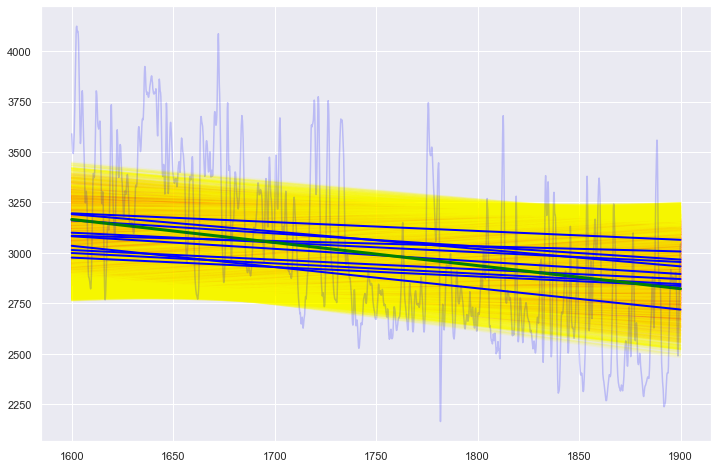

In [407]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
nr_samples = 10
lp, sample_rmse_idx = plot_velocity_predictions(ax, depth, pred_vel, rmse, cutoff, nr_samples)

In [409]:
df_output = pd.DataFrame(zip(v0[sample_rmse_idx], k[sample_rmse_idx], rmse[sample_rmse_idx]), columns=['v0','k','rmse'])
df_output

,v0,k,rmse
0,4079.312469,-0.622924,374.551492
1,3781.589255,-0.479415,387.262021
2,3875.178887,-0.484220,382.297475
3,4571.939350,-0.862338,366.069691
4,3820.943448,-0.513366,389.242474
5,3501.783029,-0.260239,396.370898
6,3896.532302,-0.437607,403.884990
7,3726.922223,-0.468730,395.359522
8,4197.073267,-0.647331,377.304874
9,4719.320265,-1.052459,375.208452


In [420]:
#todo rename index
df_output.to_csv('data/output_k_v0_pairs.csv')

AttributeError: 'list' object has no attribute 'rename'

## Clustering 

In [153]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

In [125]:
#df = gn3.df()[['VP','VS','RHOB','CGR','VWCL','PHIT']].dropna()
df = gn3.df()[['VP','VS','RHOB']].dropna()

In [126]:
df = df.rolling(100, min_periods=1).median()

In [127]:
df.count()

VP      16780
VS      16780
RHOB    16780
dtype: int64

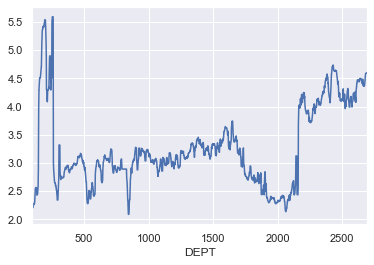

In [128]:
df['VP'].plot()

In [129]:
X = df.reset_index().values
#X = df.values

In [130]:
from sklearn.preprocessing import MinMaxScaler

In [131]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [118]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_scaled)

In [119]:
kmeans.labels_

array([0, 0, 0, ..., 1, 1, 1])

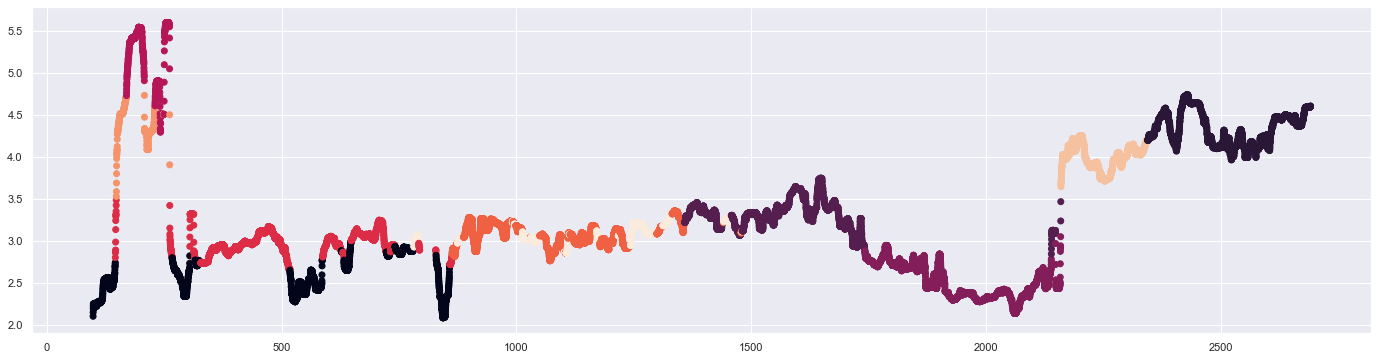

In [120]:
fig, ax = plt.subplots(1,1, figsize=(24,6))
plt.scatter(df.index, df['VP'], c=kmeans.labels_)

In [200]:
dbscan = DBSCAN(eps=0.4).fit(X)

In [201]:
dbscan.labels_

array([ 0,  0,  0, ..., 10, 10, 10], dtype=int64)

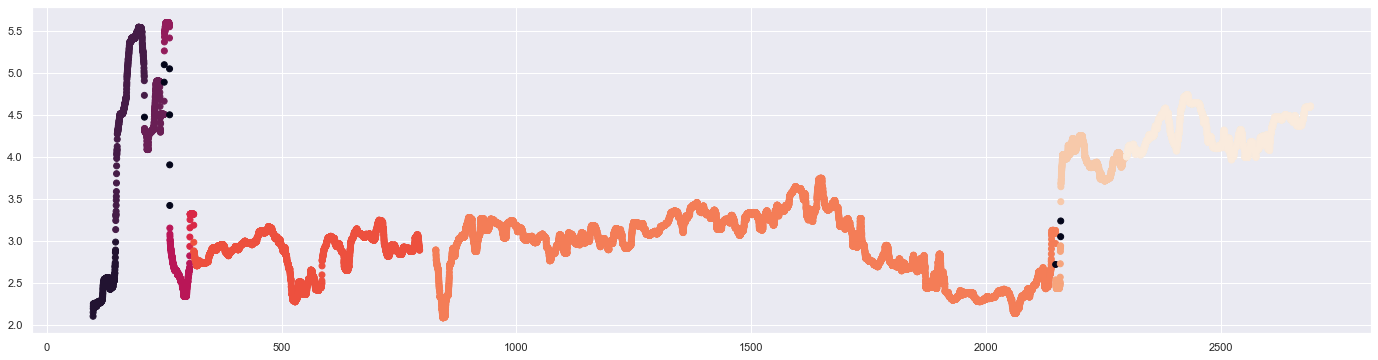

In [202]:
fig, ax = plt.subplots(1,1, figsize=(24,6))
plt.scatter(df.index, df['VP'], c=dbscan.labels_)

In [206]:
gmm = GaussianMixture(n_components=15).fit(X)

In [207]:
X_pred = gmm.predict(X)
X_pred

array([ 2,  2,  2, ..., 12, 12, 12], dtype=int64)

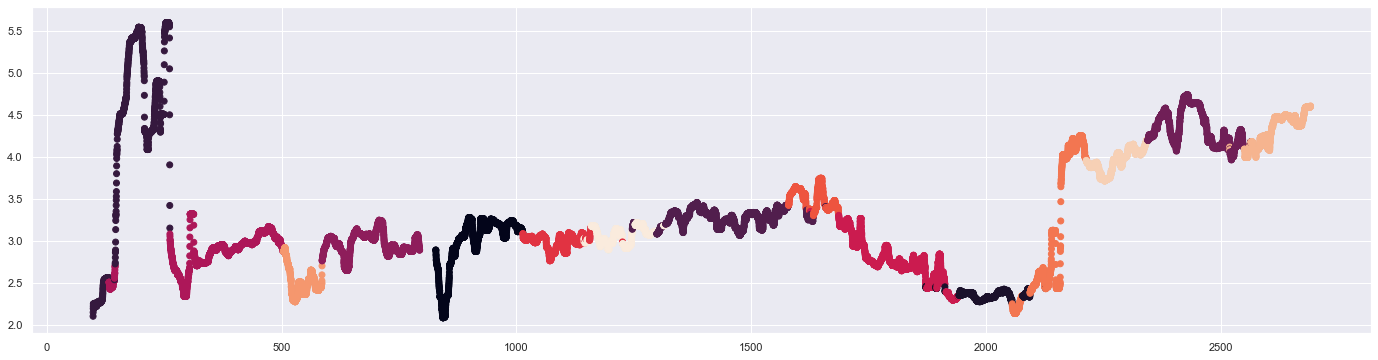

In [208]:
fig, ax = plt.subplots(1,1, figsize=(24,6))
plt.scatter(df.index, df['VP'], c=X_pred)

# Todo

* Getting to an automated low, mid, high structure model, structure volume 
* Interactive visualisation for a given V0 or K combination

## potential

* Bayesian modelling, sampling - Uncertainty quantification
* Clustering picking of formations using Gaussian Mixture Models etc..
* Run the lin_velocity function on multiple wells and formations find low error ranges for V0 and K